In [35]:
import os
import csv

import yaml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns

import torch
from torch import nn
from torch.utils.data  import DataLoader
import torchvision.transforms as transforms

from phantom import ExactPhantom
from dataset import ACRDataset, TestACRDataset
from dataset import ToTensor, Rescale

In [36]:
if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"
print(f"Using device: {device}")

Using device: mps


In [37]:
# device = "cpu"

In [38]:
# model_path = './baseline_resnet50.pt'
model_path = './model_05.pt'
ref_path = './sample_cases.yaml'
with open(ref_path, 'r') as file:
    case_dict = yaml.safe_load(file)

In [39]:
model_name = os.path.splitext(os.path.basename(model_path))[0]
outdir = os.path.join('./output', model_name)
if not os.path.exists(outdir):
    os.makedirs(outdir)

In [40]:
acr_test_dir = "./data/dl-acr-test/"
ds = TestACRDataset(acr_test_dir)

tforms = transforms.Compose([Rescale(), ToTensor()])
data_test = TestACRDataset(acr_test_dir, transform = tforms)

In [41]:
units = ["mm", "mm", "mm", r"$^{\circ}$"]

def feat_to_text(feat):
    labels = [r"$x$", r"$y$", r"$FOV$", r"$\theta$"]
    
    s = r""
    for i, val in enumerate(feat[:4]):
        s += f"{labels[i]} = {val:.1f}{units[i]}"
        if i < 3:
            s += '\n'
    return s

def pred_to_text(feat):
    labels = [r"$x$", r"$y$", r"$FOV$", r"$\theta$"]
    
    s = r""
    for i, val in enumerate(feat[:4]):
        s += f"{labels[i]}' = {val:.1f}{units[i]}"
        if i < 3:
            s += '\n'
#             s += ', '
    return s


def diff_to_text(feat1, feat2):
    labels = [r"$\Delta x$", r"$\Delta y$", r"$\Delta FOV$", r"$\Delta \theta$"]

    diff = feat1 - feat2
    
    s = r""
    for i, val in enumerate(diff[:4]):        
        s += f"{labels[i]} = {val:.1f}{units[i]}"
        if i < 3:
            s += '\n'
    return s

# test
feat_shifted_rotated = [  6.0891294,  42.634827,  250.7,    -45,     0. ]
print(feat_to_text(feat_shifted_rotated))

$x$ = 6.1mm
$y$ = 42.6mm
$FOV$ = 250.7mm
$\theta$ = -45.0$^{\circ}$


In [42]:
def GenerateRSNASummary(text=True):
    
    n_samples = len(case_dict)
    
    model = torch.load(model_path, map_location=torch.device(device))
    model.eval()
    
    fig, axs = plt.subplots(3, n_samples, figsize=(15, 10))        
    for i, key in enumerate(case_dict.keys()):
        print(key)
        
        val = case_dict[key]
        
        idx = val['n']
        feat = val['ref_feat']
        
        sample = ds[idx]['image']
        
        ########## plot input ACR phantom scan images ##########
        axs[0, i].imshow(np.squeeze(sample) ,cmap='gray', vmin=-100, vmax=100)
        axs[0, i].set_title(val['label'], fontsize=18)
        plt.subplots_adjust(wspace=None, hspace=None)

        
        ########## plot CNN model output ##########
        tensor_sample = data_test[idx]['image']
        # Run forward pass
        with torch.no_grad():
            pred = model(tensor_sample.unsqueeze(0).to(device))

        # Do something with pred
        pred = pred.detach().cpu().numpy() # remove from computational graph to cpu and as numpy
        
        # apply transformation
        transformed_img = ExactPhantom(*pred[0])
        axs[1, i].imshow(np.squeeze(transformed_img) ,cmap='gray')
        plt.subplots_adjust(wspace=None, hspace=None)
        
        
        ########## plot both outputs (overlay) ##########
        axs[2, i].imshow(np.squeeze(sample), cmap='gray', vmin=-100, vmax=100)
        axs[2, i].imshow(np.squeeze(transformed_img), cmap="viridis", alpha = 0.6)
        
        if text:
#             bbox_def = {'facecolor': 'white', 'alpha': 0.3, 'pad': 1}
            bbox_def = None
            c = 'white'
            axs[0, i].text(1, 250, feat_to_text(feat), 
                           color = c,
                           bbox=bbox_def
                          )
            axs[1, i].text(1, 250, pred_to_text(pred[0]), 
                           color = c,
                           bbox=bbox_def
                          )
            axs[2, i].text(1, 250, diff_to_text(feat, pred[0]), 
                           color = c,
                           bbox=bbox_def
                          )

        
    for a in axs.flatten():
        a.xaxis.set_major_locator(ticker.NullLocator())
        a.yaxis.set_major_locator(ticker.NullLocator())
#         a.set_xticklabels([])
#         a.set_yticklabels([])
    
    fontsize=16
    labelpad=45
    axs[0, 0].set_ylabel('Input\nTest\nImages', rotation=0, fontsize=fontsize, labelpad=labelpad)
    axs[1, 0].set_ylabel('Model\nGenerated\nOutput', rotation=0, fontsize=fontsize, labelpad=labelpad)
    axs[2, 0].set_ylabel('Overlay', rotation=0, fontsize=fontsize, labelpad=labelpad)
    

    plt.subplots_adjust(wspace=None, hspace=None)
    plt.tight_layout()
    plt.savefig(os.path.join(outdir, 'acr_cases_summary.png'))
    plt.show()

acr_normal
acr_rotated
acr_shifted_rotated
acr_med_fov
acr_lrg_fov


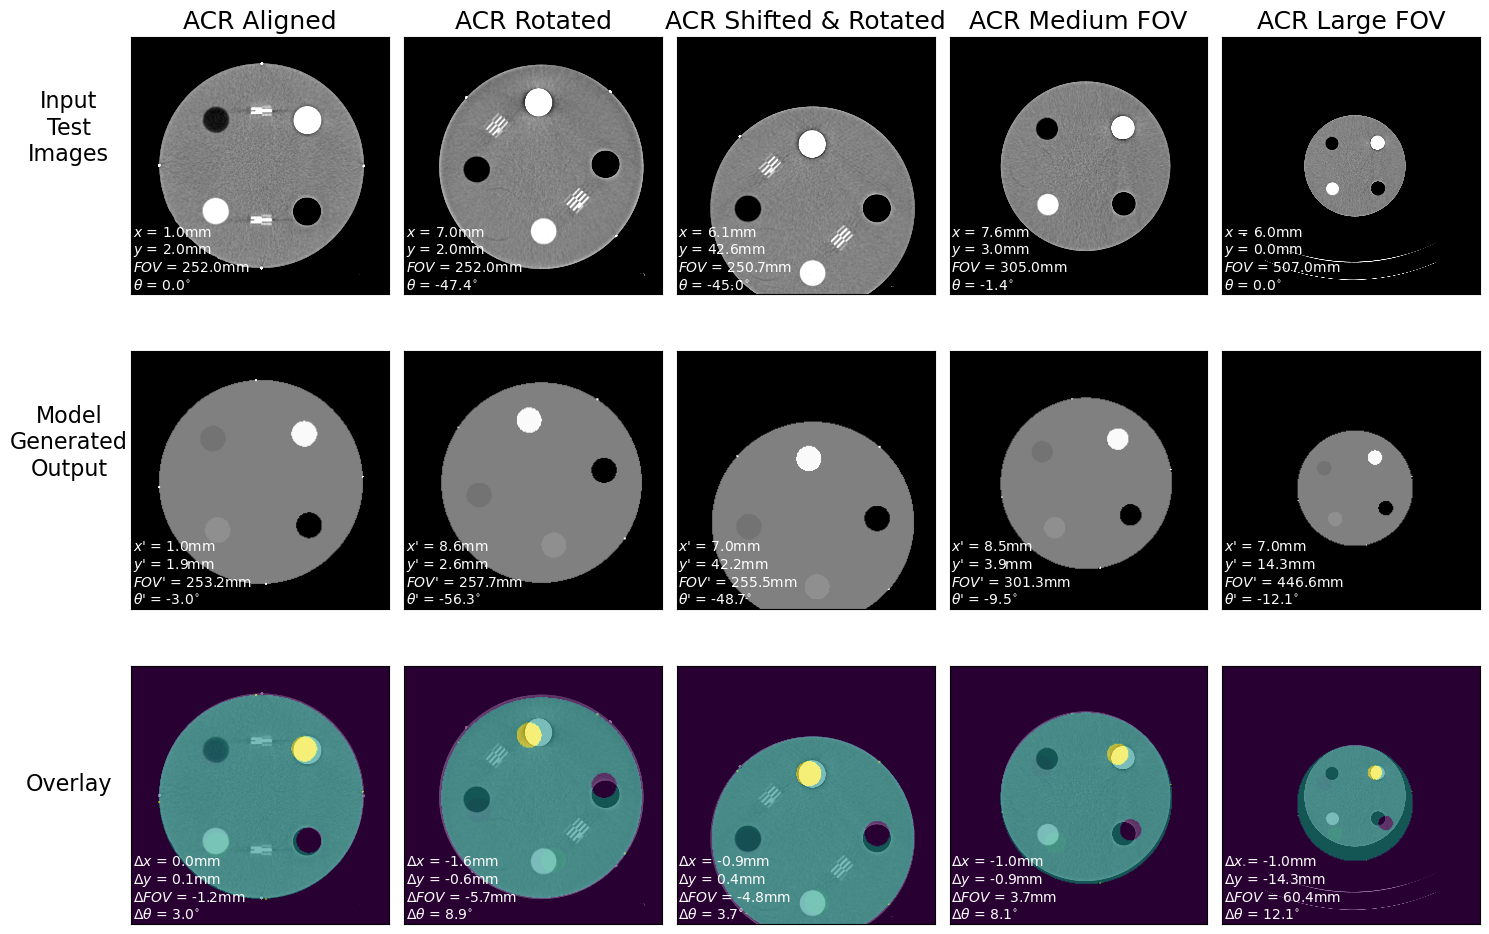

In [ ]:
GenerateRSNASummary()

# Evaluate performance on ACR phantom images

In [44]:
csv_path = os.path.join(outdir, 'acr_cases_summary.csv')

def EvalACR(csv_path):    
    n_samples = len(case_dict)
    
    model = torch.load(model_path, map_location=torch.device(device))
    model.eval()
     
    
    feature_names = ['x', 'y', 'fov', 'rot']
    
    with open(csv_path, 'w', newline='') as csvfile:
        fieldnames = ['image_type', 'index', 'description', 'feature', 'ref_value', 'pred_value', 'diff']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for i, key in enumerate(case_dict.keys()):
            
            val = case_dict[key]

            idx = val['n']
            feat = val['ref_feat']

            sample = ds[idx]['image']
            tensor_sample = data_test[idx]['image']

            # Run forward pass
            with torch.no_grad():
                pred = model(tensor_sample.unsqueeze(0).to(device))

            # Do something with pred
            pred = pred.detach().cpu().numpy() # remove from computational graph to cpu and as numpy
            
            for j, feature in enumerate(feature_names):
                writer.writerow({'image_type': 'real',
                                 'index': idx, 
                                 'description': key, 
                                 'feature': feature, 
                                 'ref_value': feat[j], 
                                 'pred_value': pred[0][j], 
                                 'diff': round(feat[j] - pred[0][j], 3)
                                })

EvalACR(csv_path)
real_df = pd.read_csv(csv_path)
real_df['abs_diff'] = real_df['diff'].abs()
real_df['perc_err'] = real_df['diff'] / real_df['ref_value']
real_df['perc_err'] = real_df['perc_err'].abs() * 100
real_df.groupby('feature')['abs_diff'].describe()

count     mean        std    min    25%    50%    75%     max
feature                                                               
fov        5.0  15.1776  25.328856  1.246  3.716  4.819  5.719  60.388
rot        5.0   7.1470   3.781378  3.003  3.687  8.086  8.905  12.054
x          5.0   0.8814   0.551144  0.028  0.875  0.956  0.980   1.568
y          5.0   3.2662   6.154179  0.092  0.434  0.623  0.920  14.262

In [45]:
csv_path = os.path.join(outdir, 'sim_cases_summary.csv')

def EvalSim(csv_path):    
    n_test = 100
    
    model = torch.load(model_path, map_location=torch.device(device))
    model.eval()
    

    tforms = transforms.Compose([Rescale(),ToTensor()])
    data_eval = ACRDataset(n_test, transform=tforms)

    kwargs = {"num_workers": 1, "pin_memory": True} if (device == "cuda") else {}

    batch_size = n_test


    eval_dataloader = DataLoader(data_eval, batch_size = batch_size, shuffle = True, **kwargs)

    with torch.no_grad():
        # M: this is not the best way to do this, sorry
        count = 0
        for batch in eval_dataloader:

            X, y = batch["image"], batch["feature_vec"]

            X = X.to(device)
            y = y.to(device)

            pred = model(X)
            pred = pred.to(device)

            diff = y.detach().cpu().numpy() - pred.detach().cpu().numpy()
            count += 1
    assert(count==1)
    
    feature_names = ['x', 'y', 'fov', 'rot']
    with open(csv_path, 'w', newline='') as csvfile:
        fieldnames = ['image_type', 'index', 'description', 'feature', 'ref_value', 'pred_value', 'diff']
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

        writer.writeheader()
        for i in range(len(diff)):

            sample = ds[i]['image']
            tensor_sample = data_test[i]['image']
            
            for j, feature in enumerate(feature_names):
                writer.writerow({'image_type': 'synthetic',
                                'index': i, 
                                 'description': None, 
                                 'feature': feature, 
                                 'ref_value': y[i][j].item(), 
                                 'pred_value': pred[i][j].item(), 
                                 'diff': y[i][j].item() - pred[i][j].item()
                                })
            
            
EvalSim(csv_path)
sim_df = pd.read_csv(csv_path)
sim_df['abs_diff'] = sim_df['diff'].abs()
sim_df['perc_err'] = sim_df['diff'] / sim_df['ref_value']
sim_df['perc_err'] = sim_df['perc_err'].abs() * 100
sim_df.groupby('feature')['abs_diff'].describe()

Using ACRPhantom dataset
Note: this is an abstract 'loader' that is really more of a 'generator'
      As currently configured, all data and feature vectors are generated on the fly


count      mean       std       min       25%       50%       75%  \
feature                                                                      
fov      100.0  1.966559  1.758216  0.014587  0.553978  1.588516  2.787994   
rot      100.0  1.395506  1.253853  0.010112  0.536120  1.222801  1.809828   
x        100.0  0.585147  0.452987  0.016364  0.231778  0.545553  0.787605   
y        100.0  0.495420  0.355429  0.013962  0.203198  0.453004  0.665850   

              max  
feature            
fov      7.839767  
rot      8.798363  
x        2.310692  
y        1.781292

In [46]:
full_df = pd.concat([sim_df, real_df])
full_df

image_type  index  description feature   ref_value  pred_value       diff  \
0   synthetic      0          NaN       x   28.676367   28.093018   0.583349   
1   synthetic      0          NaN       y   -3.360160   -3.752133   0.391973   
2   synthetic      0          NaN     fov  208.892410  212.577454  -3.685043   
3   synthetic      0          NaN     rot  -41.626122  -39.922710  -1.703411   
4   synthetic      1          NaN       x   33.082226   33.129337  -0.047112   
..        ...    ...          ...     ...         ...         ...        ...   
15       real      0  acr_med_fov     rot   -1.407085   -9.493227   8.086000   
16       real      1  acr_lrg_fov       x    6.000000    6.979715  -0.980000   
17       real      1  acr_lrg_fov       y    0.000000   14.262272 -14.262000   
18       real      1  acr_lrg_fov     fov  507.000000  446.612030  60.388000   
19       real      1  acr_lrg_fov     rot    0.000000  -12.054044  12.054000   

     abs_diff    perc_err  
0    0.583349    2.034251  
1    0.391973   11.665309  
2    3.685043    1.764087  
3    1.703411    4.092169  
4    0.047112    0.142407  
..        ...         ...  
15   8.086000  574.663304  
16   0.980000   16.333333  
17  14.262000         inf  
18  60.388000   11.910848  
19  12.054000         inf  

[420 rows x 9 columns]

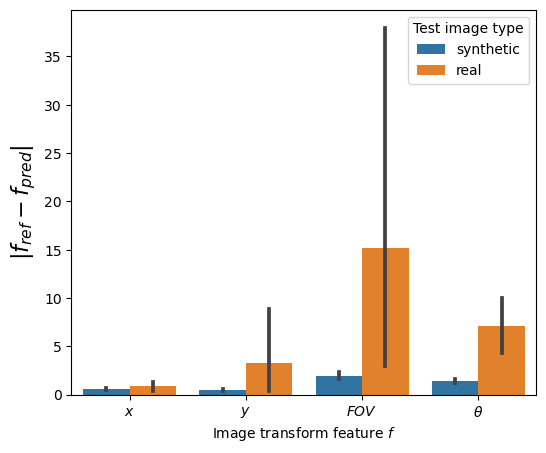

In [47]:
fig, ax = plt.subplots(1, figsize=(6, 5)) 

sns.barplot(data=full_df, x="feature", y="abs_diff",
            hue="image_type", order=None, hue_order=None, 
                estimator='mean', errorbar=('ci', 95), 
                color=None, palette=None, saturation=0.75, 
                width=0.8, errcolor='.26', errwidth=None, capsize=None, dodge=True, 
                ax=ax
               )

ax.set_ylabel('Absolute difference between reference and prediction')
ax.set_ylabel(r'$|f_{ref} - f_{pred}|$', fontsize=16)
ax.set_xlabel('Image transform feature $f$')
ax.legend(title='Test image type')
ax.set(xticklabels=["$x$", "$y$", "$FOV$", r'$\theta$'])

plt.savefig(os.path.join(outdir, 'barplot.png'))
plt.show()